<a href="https://colab.research.google.com/github/skywalker0803r/AlphaCoin/blob/main/%E7%AC%AC%E4%BA%8C%E7%AB%A0(%E5%AF%A6%E4%BD%9C%E7%8E%A9%E8%82%A1%E7%B6%B2%E7%9A%84%E7%AD%96%E7%95%A5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 延續第一章的策略類別

In [6]:
from abc import ABC, abstractmethod
import pandas as pd
import yfinance as yf
import datetime

class BaseStrategy(ABC):
    def __init__(self, data: pd.DataFrame):
        """
        :param data: 包含收盤價等欄位的歷史資料 DataFrame
        """
        self.data = data
        self.signals = pd.Series(index=self.data.index, dtype="object")

    @abstractmethod
    def generate_signals(self):
        """
        子類別實作策略邏輯，填入 self.signals（'buy', 'sell', 'hold'）
        """
        pass

    def get_signals(self) -> pd.Series:
        return self.signals

# 做出玩股網的選股程式

In [7]:
class FurongStrategy(BaseStrategy):
    def __init__(self, data: pd.DataFrame):
        super().__init__(data)
        self.data = data

    def generate_signals(self):
        close = self.data['close']

        ma5 = close.rolling(5).mean()
        ma10 = close.rolling(10).mean()
        ma20 = close.rolling(20).mean()

        # 進場條件
        cond1 = (close > ma5) & (close > ma10) & (close > ma20)
        cond2 = (close.shift(5) < ma5.shift(5)) & (close.shift(5) < ma10.shift(5)) & (close.shift(5) < ma20.shift(5))
        buy_condition = cond1 & cond2

        signals = pd.Series(index=close.index, dtype='object')
        position = False  # 持倉狀態
        entry_price = 0   # 進場價格
        holding_days = 0  # 持倉天數計數器

        for i in range(len(close)):
            price = close.iloc[i]

            if not position:
                # 尚未持倉，判斷是否進場
                if buy_condition.iloc[i]:
                    signals.iloc[i] = 'buy'
                    position = True
                    entry_price = price
                    holding_days = 1  # 第一天持倉
                else:
                    signals.iloc[i] = 'hold'
            else:
                # 持倉中，判斷是否停利/停損或超過7天出場
                change_pct = (price - entry_price) / entry_price

                holding_days += 1  # 持續計算持倉天數

                if change_pct >= 0.07:
                    signals.iloc[i] = 'sell'  # 漲7%出場
                    position = False
                    entry_price = 0
                    holding_days = 0
                elif change_pct <= -0.03:
                    signals.iloc[i] = 'sell'  # 跌3%出場
                    position = False
                    entry_price = 0
                    holding_days = 0
                elif holding_days > 7:
                    signals.iloc[i] = 'sell'  # 超過7天強制出場
                    position = False
                    entry_price = 0
                    holding_days = 0
                else:
                    signals.iloc[i] = 'hold'

        self.signals = signals

# 下載多幣種也沒問題
df = yf.download(["BTC-USD"], start="2025-01-01", end=datetime.datetime.now())

# 通用欄位標準化
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join([str(c).lower() for c in col]) for col in df.columns]
    tickers = set(col.split('_')[-1] for col in df.columns)
    if len(tickers) == 1:
        ticker_suffix = list(tickers)[0]
        df.columns = [col.replace(f"_{ticker_suffix}", '') for col in df.columns]
else:
    df.columns = df.columns.str.lower()

# 檢查是否有 close
assert 'close' in df.columns, "找不到 close 欄位"

# 建立策略
strategy = FurongStrategy(df)
strategy.generate_signals()
signals = strategy.get_signals()
signals

/tmp/ipython-input-7-1446090261.py:62: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(["BTC-USD"], start="2025-01-01", end=datetime.datetime.now())
[*********************100%***********************]  1 of 1 completed


,0
Date,
2025-01-01,hold
2025-01-02,hold
2025-01-03,hold
2025-01-04,hold
2025-01-05,hold
...,...
2025-06-22,hold
2025-06-23,buy
2025-06-24,hold


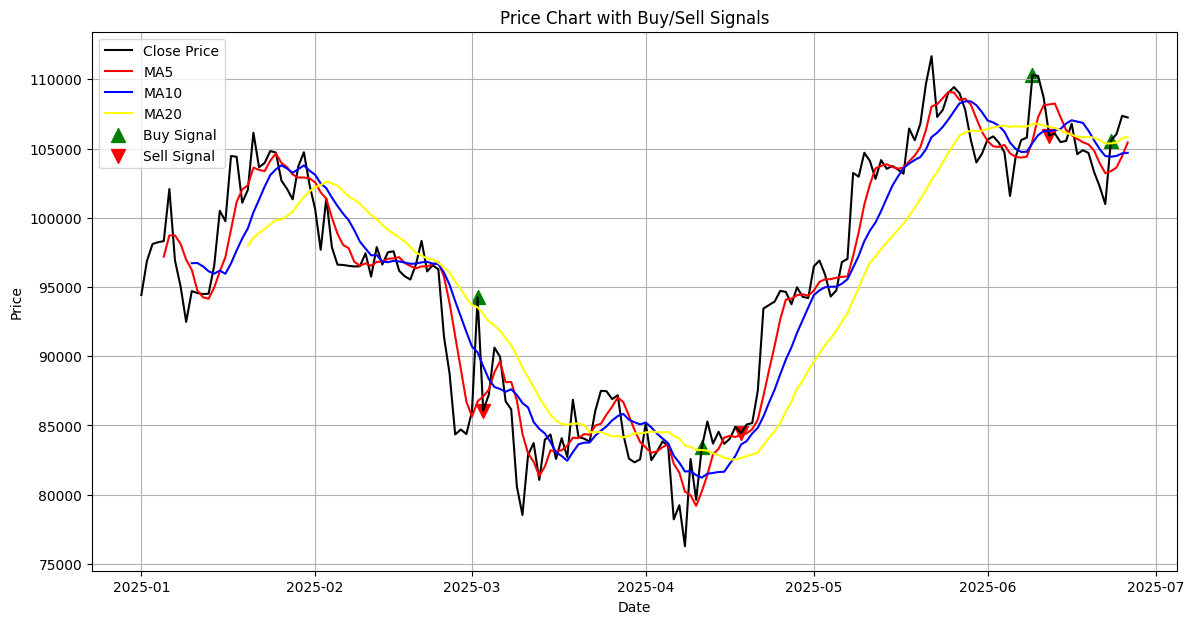

In [8]:
import matplotlib.pyplot as plt

signals = strategy.get_signals()
close = df['close']

plt.figure(figsize=(14, 7))
plt.plot(close.index, close, label='Close Price', color='black')
plt.plot(close.index, close.rolling(5).mean(), label='MA5', color='red')
plt.plot(close.index, close.rolling(10).mean(), label='MA10', color='blue')
plt.plot(close.index, close.rolling(20).mean(), label='MA20', color='yellow')

# 買點用綠色三角形標記
buy_signals = signals == 'buy'
plt.scatter(close.index[buy_signals], close[buy_signals], marker='^', color='green', label='Buy Signal', s=100)

# 賣點用紅色倒三角形標記
sell_signals = signals == 'sell'
plt.scatter(close.index[sell_signals], close[sell_signals], marker='v', color='red', label='Sell Signal', s=100)

plt.title('Price Chart with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
